In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from PIL import Image
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from skimage import color
from skimage.feature import hog
from skimage import data, exposure

# Train

#### Load Pneumonia class images

In [38]:
train_x=[]

path=r'xray\train\PNEUMONIA\*.jpeg'

for filename in glob.glob(path): 
    im=Image.open(filename).convert('L') #converts RGB images to grayscale
    img = im.resize((100, 100)) #resize to 100*100
    train_x.append(tf.keras.preprocessing.image.img_to_array(img))

#### Create label zeros for class Pneumonia

In [39]:
a=len(train_x)
train_y=np.zeros(a)

#### Load COVID-19 class images

In [40]:
path=r'xray\train\covid1000\*'

for filename in glob.glob(path): 
    im=Image.open(filename).convert('L') #converts RGB images to grayscale
    img = im.resize((100, 100)) #resize to 100*100
    train_x.append(tf.keras.preprocessing.image.img_to_array(img))

#### Create label ones for class COVID-19

In [41]:
b=len(train_x)
trainy=np.concatenate((train_y,np.ones(b-a)))

#### Load Normal class images

In [42]:
path=r'xray\train\NORMAL\*.jpeg'

for filename in glob.glob(path): 
    im=Image.open(filename).convert('L') #converts RGB images to grayscale
    img = im.resize((100, 100)) #resize to 100*100
    train_x.append(tf.keras.preprocessing.image.img_to_array(img))

#### Create label twos for class Normal 

In [43]:
c=len(train_x)
trainyy=np.concatenate((trainy,np.full(c-b, 2.)))

In [44]:
trainx = np.stack(train_x) # Converts the list of arrays to a array of arrays

#### Extract HOG features from the images

In [45]:
hog_images = []
hog_features = []
for image in trainx:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(10, 10),cells_per_block=(1, 1), visualize=True, multichannel=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

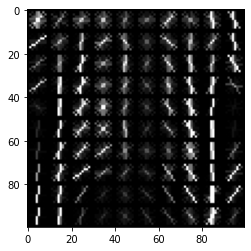

In [106]:
hog_image_rescaled = exposure.rescale_intensity(hog_images[15], in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

#### Save the example images

In [119]:
im = Image.fromarray(hog_images[15]*25.5)
im.convert("L").save("HOG.png")

In [95]:
im = Image.fromarray(trainx[15].reshape(100,100))
im.convert("L").save("trainx.png")

#### Train Support Vector Machine model

In [47]:
from sklearn import svm
clf = svm.SVC()
x_train = np.array(hog_features)
y_train = trainyy.reshape(len(trainyy),1)

In [48]:
clf.fit(x_train,y_train)

D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

# Test

#### Load Pneumonia class images

In [49]:
test_x=[]

path=r'xray\test\PNEUMONIA\*.jpeg'

for filename in glob.glob(path): 
    im=Image.open(filename).convert('L') #converts RGB images to grayscale
    img = im.resize((100, 100)) #resize to 100*100
    test_x.append(tf.keras.preprocessing.image.img_to_array(img))

#### Create label zeros for class Pneumonia

In [50]:
a=len(test_x)
test_y=np.zeros(a)

#### Load COVID-19 class images

In [51]:
path=r'xray\test\covid1000\*'

for filename in glob.glob(path): 
    im=Image.open(filename).convert('L') #converts RGB images to grayscale
    img = im.resize((100, 100)) #resize to 100*100
    test_x.append(tf.keras.preprocessing.image.img_to_array(img))

#### Create label ones for class COVID-19

In [52]:
b=len(test_x)
testy=np.concatenate((test_y,np.ones(b-a)))

#### Load Normal class images

In [53]:
path=r'xray\test\NORMAL\*.jpeg'

for filename in glob.glob(path): 
    im=Image.open(filename).convert('L') #converts RGB images to grayscale
    img = im.resize((100, 100)) #resize to 100*100
    test_x.append(tf.keras.preprocessing.image.img_to_array(img))

#### Create label twos for class COVID-19

In [54]:
c=len(test_x)
testyy=np.concatenate((testy,np.full(c-b, 2.)))

In [55]:
testx = np.stack(test_x) # Converts the list of arrays to a array of arrays

#### Extract HOG features from the images

In [56]:
hog_images = []
hog_features = []
for image in testx:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(10, 10),cells_per_block=(1, 1), visualize=True, multichannel=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [57]:
y_test = testyy.reshape(len(testyy),1)

In [58]:
x_test = np.array(hog_features)

#### Prediction for SVM

In [63]:
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.799059929494712


[[386   1   3]
 [ 13 213   1]
 [133  20  81]]


              precision    recall  f1-score   support

         0.0       0.73      0.99      0.84       390
         1.0       0.91      0.94      0.92       227
         2.0       0.95      0.35      0.51       234

    accuracy                           0.80       851
   macro avg       0.86      0.76      0.76       851
weighted avg       0.84      0.80      0.77       851



#### Train Logistic Regression model

In [64]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)

D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

#### Prediction for Logistic Regression

In [66]:
y_pred = logmodel.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.8143360752056404


[[385   0   5]
 [ 12 214   1]
 [126  14  94]]


              precision    recall  f1-score   support

         0.0       0.74      0.99      0.84       390
         1.0       0.94      0.94      0.94       227
         2.0       0.94      0.40      0.56       234

    accuracy                           0.81       851
   macro avg       0.87      0.78      0.78       851
weighted avg       0.85      0.81      0.79       851



#### Prediction for k-NN when k=8

In [67]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 8)
classifier.fit(x_train, y_train)

D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(n_neighbors=8)

#### Prediction for k-NN

In [68]:
y_pred = classifier.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.7297297297297297


[[379   1  10]
 [ 57 163   7]
 [140  15  79]]


              precision    recall  f1-score   support

         0.0       0.66      0.97      0.78       390
         1.0       0.91      0.72      0.80       227
         2.0       0.82      0.34      0.48       234

    accuracy                           0.73       851
   macro avg       0.80      0.68      0.69       851
weighted avg       0.77      0.73      0.71       851



#### Select 200 images from each class

In [73]:
x_arr = np.concatenate((trainx[0:200,:], trainx[4000:4200,:], trainx[6000:6200,:], testx[0:200,:], testx[390:590,:], testx[620:820,:]))
x_arr = x_arr.reshape(1200,10000)
y_arr=np.concatenate((np.zeros(200),np.ones(200),np.full(200, 2.),np.full(200, 3.),np.full(200, 4.),np.full(200, 5.)))

#### Generate t-SNE visualizations

D:\anaconda3\envs\tfgpu\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


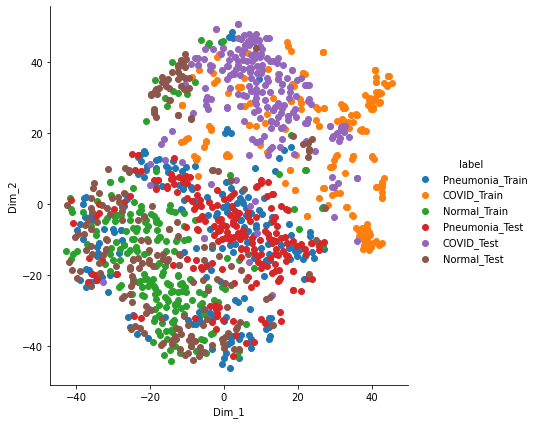

In [86]:
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(x_arr)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_arr)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
tsne_df.loc[tsne_df.label == 5.0, "label"] = "Normal_Test"
tsne_df.loc[tsne_df.label == 4.0, "label"] = "COVID_Test"
tsne_df.loc[tsne_df.label == 3.0, "label"] = "Pneumonia_Test"
tsne_df.loc[tsne_df.label == 2.0, "label"] = "Normal_Train"
tsne_df.loc[tsne_df.label == 1.0, "label"] = "COVID_Train"
tsne_df.loc[tsne_df.label == 0.0, "label"] = "Pneumonia_Train"
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.savefig('TSNE.png')
plt.show()

#### Generate PCA visualization

D:\anaconda3\envs\tfgpu\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


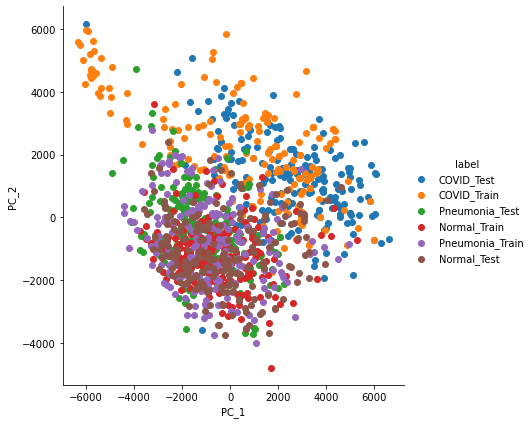

In [87]:
from sklearn.decomposition import PCA
import seaborn as sn
model = PCA(n_components=2, random_state=0)
pca_data = model.fit_transform(x_arr)
# creating a new data frame which help us in ploting the result data
pca_data = np.vstack((pca_data.T, y_arr)).T
pca_df = pd.DataFrame(data=pca_data, columns=("PC_1", "PC_2", "label"))
pca_df = pca_df.sample(frac=1).reset_index(drop=True)
pca_df.loc[pca_df.label == 5.0, "label"] = "Normal_Test"
pca_df.loc[pca_df.label == 4.0, "label"] = "COVID_Test"
pca_df.loc[pca_df.label == 3.0, "label"] = "Pneumonia_Test"
pca_df.loc[pca_df.label == 2.0, "label"] = "Normal_Train"
pca_df.loc[pca_df.label == 1.0, "label"] = "COVID_Train"
pca_df.loc[pca_df.label == 0.0, "label"] = "Pneumonia_Train"
# Ploting the result of PCA
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, 'PC_1', 'PC_2').add_legend()
plt.savefig('PCA.png')
plt.show()